In [1]:
import pandas as pd
import eia
import requests
import json
from prophet import Prophet

# Definitions
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
pd.set_option('display.max_columns', 100)    #Display upto 100 columns 
pd.set_option('display.max_rows', 100) 
%matplotlib inline

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')   

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
# To be able to pull modules from src folder 
import os
import sys
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

## Pulling Raw Data 
So far, this pulls raw data for Total Net Generation from EIA API for all states in yaml. Eventually this will be extended to pull more types of data (such as generation by fuels, btu consumption by fuel, etc.) 

In [5]:
from d00_utils.utils import setup_env_vars
from d01_data.get_raw_data import get_raw_data

setup_env_vars()
get_raw_data()

## Intermediate / Processed Data

In [28]:
# search.json()['series'][0]['data']
search.json()['series']

# Create dataframe 
df = pd.DataFrame(search.json()['series'][0]['data'])
df.columns=["year_quarter", "Net_Generation"]
df

,year_quarter,Net_Generation
0,2021Q3,39835.274
1,2021Q2,32450.840
2,2021Q1,34144.667
3,2020Q4,32301.295
4,2020Q3,39516.706
5,2020Q2,32812.276
6,2020Q1,32912.425
7,2019Q4,33982.381
8,2019Q3,39742.990
9,2019Q2,34542.705


In [29]:
# Convert Year-Quarter into datetime format 
qs = df['year_quarter'].str.replace(r'(\d+)(Q\d)', r'\1-\2') 
qs 

df['date'] = pd.PeriodIndex(qs, freq='Q').to_timestamp() 
df['date'] = df['date'] + pd.offsets.QuarterEnd(0)
df

,year_quarter,Net_Generation,date
0,2021Q3,39835.274,2021-09-30
1,2021Q2,32450.840,2021-06-30
2,2021Q1,34144.667,2021-03-31
3,2020Q4,32301.295,2020-12-31
4,2020Q3,39516.706,2020-09-30
5,2020Q2,32812.276,2020-06-30
6,2020Q1,32912.425,2020-03-31
7,2019Q4,33982.381,2019-12-31
8,2019Q3,39742.990,2019-09-30
9,2019Q2,34542.705,2019-06-30


In [30]:
# Format data for prophet model using ds and y
df.drop('year_quarter', axis=1, inplace=True)
df = df.rename(columns={'date':'ds', 'Net_Generation':'y'})

In [31]:
# df.info()
df.head()

,y,ds
0,39835.274,2021-09-30
1,32450.840,2021-06-30
2,34144.667,2021-03-31
3,32301.295,2020-12-31
4,39516.706,2020-09-30


## Testing Prophet 

In [32]:
m = Prophet()
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -90.7397
Iteration  1. Log joint probability =     101.09. Improved by 191.83.
Iteration  2. Log joint probability =    152.338. Improved by 51.2477.
Iteration  3. Log joint probability =    202.528. Improved by 50.1907.
Iteration  4. Log joint probability =    219.155. Improved by 16.6265.
Iteration  5. Log joint probability =    219.197. Improved by 0.0424827.
Iteration  6. Log joint probability =    223.349. Improved by 4.15211.
Iteration  7. Log joint probability =    224.007. Improved by 0.657233.
Iteration  8. Log joint probability =    226.755. Improved by 2.74808.
Iteration  9. Log joint probability =    238.052. Improved by 11.2974.
Iteration 10. Log joint probability =     243.12. Improved by 5.06797.
Iteration 11. Log joint probability =    243.281. Improved by 0.161307.
Iteration 12. Log joint probability =    245.026. Improved by 1.74467.
Iteration 13. Log joint probability =    247.957. Improved by 2.93105.
Iteration 14. Log joint probabil

In [33]:
future = m.make_future_dataframe(periods=16, freq='Q')
future.tail()

,ds
94,2024-09-30
95,2024-12-31
96,2025-03-31
97,2025-06-30
98,2025-09-30


roved by 0.000145702.
Iteration 84. Log joint probability =     257.15. Improved by 0.000166972.
Iteration 85. Log joint probability =     257.15. Improved by 0.000356966.
Iteration 86. Log joint probability =     257.15. Improved by 0.000329468.
Iteration 87. Log joint probability =    257.151. Improved by 0.000336377.
Iteration 88. Log joint probability =    257.151. Improved by 0.0002952.
Iteration 89. Log joint probability =    257.151. Improved by 0.000176184.
Iteration 90. Log joint probability =    257.151. Improved by 5.08723e-05.
Iteration 91. Log joint probability =    257.151. Improved by 9.27552e-05.
Iteration 92. Log joint probability =    257.151. Improved by 5.42568e-05.
Iteration 93. Log joint probability =    257.151. Improved by 7.51499e-05.
Iteration 94. Log joint probability =    257.151. Improved by 2.68486e-05.
Iteration 95. Log joint probability =    257.151. Improved by 3.34962e-05.
Iteration 96. Log joint probability =    257.151. Improved by 1.35958e-05.
Itera

In [34]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
94,2024-09-30,37604.705,36189.315,39074.119
95,2024-12-31,31065.140,29672.361,32453.261
96,2025-03-31,31725.660,30426.535,33145.001
97,2025-06-30,31488.515,30118.055,32847.973
98,2025-09-30,36666.583,35352.570,38165.075


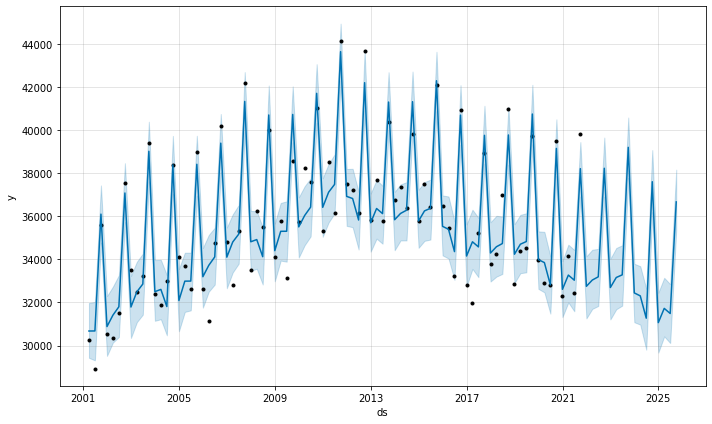

In [35]:
fig1 = m.plot(forecast)

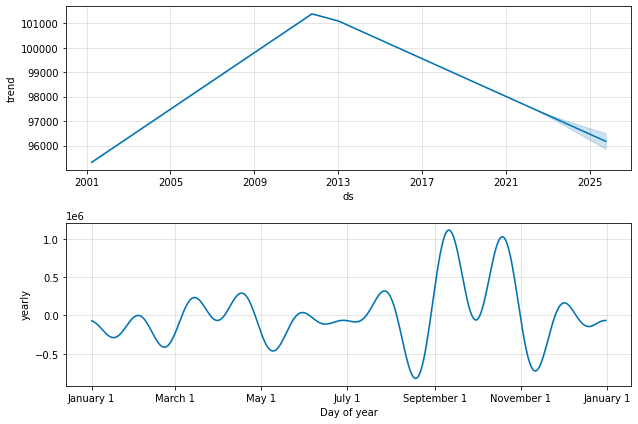

In [36]:
fig2 = m.plot_components(forecast)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)
plot_components_plotly(m, forecast)


## Match Emissions to Net Generation 
Setup basic API calls to ClimatIQ or similar emissions API 

In [57]:
climatiq_api_key = 'EWG5XPRGT94V25G2CNYH8V7HJFE9' 
estimate_url = 'https://beta3.api.climatiq.io/estimate' 

In [60]:
headers = {'Authorization': 'Bearer {}'.format(climatiq_api_key)}

data = {
        "emission_factor": "electricity-energy_source_grid_mix",
        "parameters":
            {
            "energy": 1,
            "energy_unit": "kWh"
            }
 }

data_2 = {
    "emission_factor": {
        "id": "electricity-energy_source_grid_mix",
        # "source": "MfE",
        "region": "US-AL",
        # "year": "2020"
    },
    "parameters": {
        "energy": 1,
        "energy_unit": "kWh"
    }
}

response = requests.post(url=estimate_url, data=json.dumps(data_2), headers=headers)
response

<Response [200]>

In [61]:
response.json()

{'co2e': 0.356329628,
 'co2e_unit': 'kg',
 'co2e_calculation_method': 'ar4',
 'co2e_calculation_origin': 'source',
 'emission_factor': {'id': 'electricity-energy_source_grid_mix',
  'source': 'EPA',
  'year': '2021',
  'region': 'US-AL',
  'category': 'Electricity',
  'lca_activity': 'usephase'},
 'constituent_gases': {'co2e_total': 0.356329628,
  'co2e_other': None,
  'co2': None,
  'ch4': None,
  'n2o': None}}

In [64]:
alabama_emissions_per_kwh = response.json()['co2e']
alabama_emissions_per_kwh

0.356329628

In [54]:
region_url = 'https://beta3.api.climatiq.io/emission-factors/regions?year=2021'

custom_region_url = {'https://beta3.api.climatiq.io/emission-factors/regions?id={}'.format(climatiq_api_key)}
data_2 = {
        "emission_factor": "electricity-energy_source_grid_mix",
        "parameters":
            {
            "energy": 1,
            "energy_unit": "kWh"
            }
 }

# response_2 = requests.post(url=region_url, data=json.dumps(data_2), headers=headers)
response_2 = requests.get(url=region_url, headers=headers)
response_2

<Response [200]>

In [55]:
response_2.json()

{'results': [{'id': 'AE', 'name': 'United Arab Emirates'},
  {'id': 'AF', 'name': 'Afghanistan'},
  {'id': 'AR', 'name': 'Argentina'},
  {'id': 'AT', 'name': 'Austria'},
  {'id': 'AU', 'name': 'Australia'},
  {'id': 'AU-ACT', 'name': 'Australian Capital Territory, AU'},
  {'id': 'AU-NSW', 'name': 'New South Wales, AU'},
  {'id': 'AU-NT', 'name': 'Northern Territory, AU'},
  {'id': 'AU-QLD', 'name': 'Queensland, AU'},
  {'id': 'AU-SA', 'name': 'South Australia, AU'},
  {'id': 'AU-SYD', 'name': 'Sydney, NSW, AU'},
  {'id': 'AU-TAS', 'name': 'Tasmania, AU'},
  {'id': 'AU-VIC', 'name': 'Victoria, AU'},
  {'id': 'AU-WA', 'name': 'Western Australia, AU'},
  {'id': 'BE', 'name': 'Belgium'},
  {'id': 'BE-GHI', 'name': 'Saint-Ghislain, WHT, BE'},
  {'id': 'BG', 'name': 'Bulgaria'},
  {'id': 'BH-AMH', 'name': 'Al Manamah, 13, BH'},
  {'id': 'BL', 'name': 'Saint Barthélemy'},
  {'id': 'BR', 'name': 'Brazil'},
  {'id': 'BR-SAO', 'name': 'São Paulo, SP, BR'},
  {'id': 'CA', 'name': 'Canada'},
  {'i

## Combine Forecast with Emissions 

In [62]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
94,2024-09-30,37604.705,36189.315,39074.119
95,2024-12-31,31065.140,29672.361,32453.261
96,2025-03-31,31725.660,30426.535,33145.001
97,2025-06-30,31488.515,30118.055,32847.973
98,2025-09-30,36666.583,35352.570,38165.075


In [69]:
forecast['emissions_million_tCO2e'] = (alabama_emissions_per_kwh * 1000 * forecast.yhat) / 1e6
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,emissions_tCO2e,emissions_million_tCO2e
0,2001-03-31,95315.233,29430.902,31980.173,95315.233,95315.233,-64639.681,-64639.681,-64639.681,-64639.681,-64639.681,-64639.681,0.000,0.000,0.000,30675.552,10930608.083,10.931
1,2001-06-30,95459.394,29314.784,32022.741,95459.394,95459.394,-64780.573,-64780.573,-64780.573,-64780.573,-64780.573,-64780.573,0.000,0.000,0.000,30678.822,10931773.089,10.932
2,2001-09-30,95605.140,34781.257,37432.117,95605.140,95605.140,-59505.193,-59505.193,-59505.193,-59505.193,-59505.193,-59505.193,0.000,0.000,0.000,36099.947,12863480.659,12.863
3,2001-12-31,95750.885,29521.297,32297.157,95750.885,95750.885,-64869.821,-64869.821,-64869.821,-64869.821,-64869.821,-64869.821,0.000,0.000,0.000,30881.064,11003837.962,11.004
4,2002-03-31,95893.462,30139.764,32733.657,95893.462,95893.462,-64483.976,-64483.976,-64483.976,-64483.976,-64483.976,-64483.976,0.000,0.000,0.000,31409.486,11192130.580,11.192


# Appendix 

## EIA API Wrapper Function

In [23]:
api_key = "xPWAeqwYEwqmxA0hFnjsCUbcyxEG95ajpq4aX89p"
api = eia.API(api_key)

In [24]:
# EIA API Run - NOT Working
def retrieve_data():
    # Create EIA API using your specific API key
    api_key = "xPWAeqwYEwqmxA0hFnjsCUbcyxEG95ajpq4aX89p"
    api = eia.API(api_key)

    # Retrieve Data By Series ID 
    series_ID='ELEC.GEN.ALL-AL-99.Q'
    series_ID='EMISS.CO2-TOTV-TT-NG-TX.A'
    series_search = api.data_by_series(series=series_ID)
    df = pd.DataFrame(series_search)    
    # df.index.names = ['Date']
    # df.columns=[ "Price"]
    # df.index = df.index.str.replace('^([\d]{4})\s([\d]{2})([\d]{2})\s[\d]{2}', r'\1-\2-\3',regex=True)
    # df.index = pd.to_datetime(df.index)

    return df

# df = retrieve_data()
# df

In [25]:
# Copied EIA code over manually which works :/ 
def data_by_series(api_key, series):
    """
    API Series Query
    :param series: string
    :return: Returns eia data series in dictionary form
    (name, units, frequency, and series ID) based on series ID.
    """
    url_data = 'https://api.eia.gov/series/?series_id={}&api_key={}&out=json'
    values_dict = {}
    search = requests.get(url_data.format(series, api_key))
    if search.json().get('data') and \
            search.json().get('data').get('error') == \
            glob_invalid_api_key:
        error_msg = search.json().get('data').get('error')
        raise APIKeyError(error_msg)

    elif search.json().get('data') \
            and search.json().get('data').get('error') == \
            glob_invalid_series_id:
            error_msg = search.json()['data']['error']
            raise InvalidSeries(error_msg)

    else:
        lst_dates = [x[0][0:4] + " " + x[0][4:] + " " + x[0][6:8]
                     for x in search.json()['series'][0]['data']]
        lst_values = [x[1] for x in
                      search.json()['series'][0]['data']]
        dates_values_dict = dict(zip(lst_dates, lst_values))
        values_dict[search.json()['series'][0]['name'] +
                    " (" +
                    search.json()['series'][0]['units'] +
                    ")"] = \
            dates_values_dict
        return values_dict

In [26]:
# Currently adds extra spaces to year-quarter date making downstream date conversion annoying

# series_ID='ELEC.GEN.ALL-AL-99.Q'
# series_search = data_by_series(api_key, series=series_ID)
# df = pd.DataFrame(series_search).reset_index()    
# df.columns=["year_quarter", "Net_Generation"]
# df